In [1]:
import os
from google.colab import files
import json

# Step 1: Upload Kaggle API Token
uploaded = files.upload()

# Save the uploaded file to ~/.kaggle/kaggle.json
os.makedirs("~/.kaggle", exist_ok=True)
with open("~/.kaggle/kaggle.json", "w") as f:
    json.dump(json.load(open(list(uploaded.keys())[0])), f)

# Set permissions for the Kaggle API token
os.chmod("~/.kaggle/kaggle.json", 600)

# Step 2: Install Kaggle package
!pip install kaggle

# Step 3: Define Dataset Path or Dataset Name
dataset_path = "saurav9786/amazon-product-reviews"  # Replace this with the dataset path or name

# Step 4: Download Dataset from Kaggle (using the dataset path)
!kaggle datasets download -d {dataset_path}  # Replace {dataset_path} with the correct dataset path

# Step 5: Unzip the Dataset
dataset_filename = "<dataset-name>.zip"  # Replace with your dataset's zip filename
!unzip -q {dataset_filename}  # Unzips the downloaded dataset file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews
License(s): unknown
 93% 102M/109M [00:00<00:00, 128MB/s] 
100% 109M/109M [00:00<00:00, 131MB/s]
/bin/bash: line 1: dataset-name: No such file or directory


In [2]:
import zipfile

# Path to the uploaded zip file
zip_file_path = '/content/amazon-product-reviews.zip'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Specify the directory where to unzip

print(f"Unzipped {zip_file_path} to /content/")


Unzipped /content/amazon-product-reviews.zip to /content/


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("/content/ratings_Electronics (1).csv",
                             names=['userId', 'productId','rating','timestamp'])

In [5]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [7]:
!pip install pyspark py4j

In [8]:
from pyspark.sql import SparkSession

In [9]:
spark=SparkSession.builder.appName("test_pyspark").getOrCreate()

In [12]:
# Convert pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(df)

# Show the schema and the first few rows
df_spark.printSchema()
df_spark.show(5)


root
 |-- userId: string (nullable = true)
 |-- productId: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)

+--------------+----------+------+----------+
|        userId| productId|rating| timestamp|
+--------------+----------+------+----------+
| AKM1MP6P0OYPR|0132793040|   5.0|1365811200|
|A2CX7LUOHB2NDG|0321732944|   5.0|1341100800|
|A2NWSAGRHCP8N5|0439886341|   1.0|1367193600|
|A2WNBOD3WNDNKT|0439886341|   3.0|1374451200|
|A1GI0U4ZRJA8WN|0439886341|   1.0|1334707200|
+--------------+----------+------+----------+
only showing top 5 rows



In [13]:
# Get the total number of rows in a PySpark DataFrame
num_rows = df_spark.count()
print("Total Reviews:", num_rows)


Total Reviews: 5000


In [14]:
# Get the total number of columns in a PySpark DataFrame
num_columns = len(df_spark.columns)
print("Total Columns:", num_columns)


Total Columns: 4


In [15]:
# Total number of unique ratings
num_ratings = df_spark.select("rating").distinct().count()
print("Total number of ratings:", num_ratings)

# Total number of unique users
num_users = df_spark.select("userId").distinct().count()
print("Total number of users:", num_users)

# Total number of unique products
num_products = df_spark.select("productId").distinct().count()
print("Total number of products:", num_products)


Total number of ratings: 5
Total number of users: 4929
Total number of products: 299


In [16]:
df_spark.printSchema()


root
 |-- userId: string (nullable = true)
 |-- productId: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [17]:
from pyspark.sql.functions import col, sum

# Calculate the number of null values in each column
null_counts = df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])

# Show the result
null_counts.show()


+------+---------+------+---------+
|userId|productId|rating|timestamp|
+------+---------+------+---------+
|     0|        0|     0|        0|
+------+---------+------+---------+



In [18]:
# Check for duplicate rows in the DataFrame
duplicates_count = df_spark.count() - df_spark.dropDuplicates().count()

# If the count of duplicates is greater than 0, there are duplicate rows
if duplicates_count > 0:
    print(f"There are {duplicates_count} duplicate rows.")
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [19]:
# Get a summary of the 'rating' column
df_spark.describe('rating').show()


+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|              5000|
|   mean|            3.9866|
| stddev|1.4118141109284759|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



In [20]:
# Get unique values of the 'rating' column
unique_ratings = df_spark.select("rating").distinct().collect()

# Print the unique values
print("Unique values of Rating:", [row['rating'] for row in unique_ratings])


Unique values of Rating: [1.0, 4.0, 3.0, 2.0, 5.0]


In [21]:
# Find the minimum and maximum ratings
min_rating = df_spark.agg({"rating": "min"}).collect()[0][0]
max_rating = df_spark.agg({"rating": "max"}).collect()[0][0]

# Print the results
print('Minimum rating is:', min_rating)
print('Maximum rating is:', max_rating)


Minimum rating is: 1.0
Maximum rating is: 5.0


In [22]:
from pyspark.sql import functions as F

# Group by 'productId' and calculate average rating and rating count
ratings = df_spark.groupBy('productId') \
    .agg(
        F.avg('rating').alias('ratings_average'),  # Average rating
        F.count('rating').alias('ratings_count')   # Count of ratings
    )

# Show the first 10 rows
ratings.show(10)


+----------+------------------+-------------+
| productId|   ratings_average|ratings_count|
+----------+------------------+-------------+
|0528881469|2.8518518518518516|           27|
|1400532620|3.6842105263157894|          171|
|0594450705|               5.0|            1|
|0777700018|               5.0|            2|
|1400501474| 4.448275862068965|           29|
|0594033896|               4.4|            5|
|0977703037|               4.0|            1|
|0970407998|               3.2|            5|
|0594450209|               5.0|            2|
|0594287995|               5.0|            1|
+----------+------------------+-------------+
only showing top 10 rows



In [23]:
# Show the first 5 rows of the DataFrame
df_spark.show(5)


+--------------+----------+------+----------+
|        userId| productId|rating| timestamp|
+--------------+----------+------+----------+
| AKM1MP6P0OYPR|0132793040|   5.0|1365811200|
|A2CX7LUOHB2NDG|0321732944|   5.0|1341100800|
|A2NWSAGRHCP8N5|0439886341|   1.0|1367193600|
|A2WNBOD3WNDNKT|0439886341|   3.0|1374451200|
|A1GI0U4ZRJA8WN|0439886341|   1.0|1334707200|
+--------------+----------+------+----------+
only showing top 5 rows



['userId', 'productId', 'rating', 'timestamp']
           userId   productId  rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200


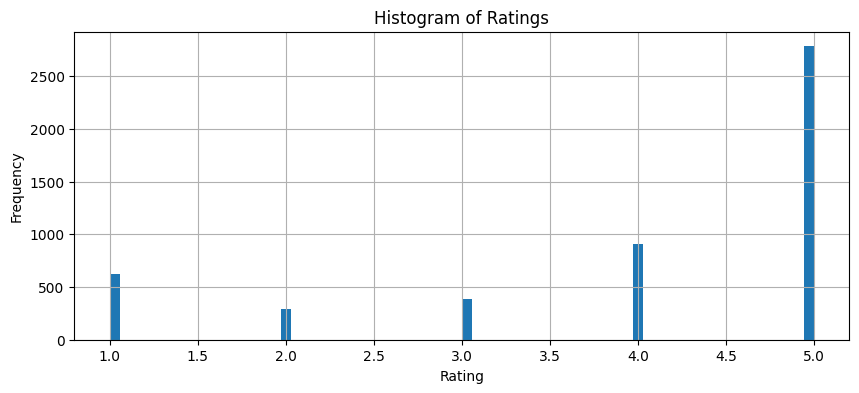

In [26]:
import matplotlib.pyplot as plt  # Import the pyplot submodule

# Check column names in the DataFrame to make sure 'rating' exists
print(df_spark.columns)  # Print the column names

# Collect the ratings data into a Pandas DataFrame
ratings_pd = df_spark.toPandas()

# Verify the first few rows to see the 'rating' column
print(ratings_pd.head())

# Create a figure with the specified size
plt.figure(figsize=(10, 4))

# Plot the histogram of the 'rating' column
ratings_pd['rating'].hist(bins=70)

# Add labels and title
plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()


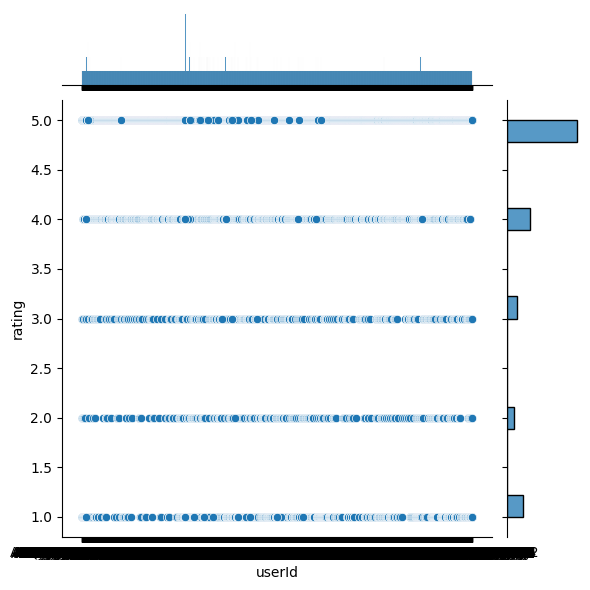

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert Spark DataFrame to Pandas DataFrame
df_spark_pd = df_spark.toPandas()

# Step 2: Create a jointplot (example: between 'userId' and 'rating')
sns.jointplot(x='userId', y='rating', data=df_spark_pd, kind='scatter')  # You can change kind to 'hex' or 'kde'

# Step 3: Display the plot
plt.show()


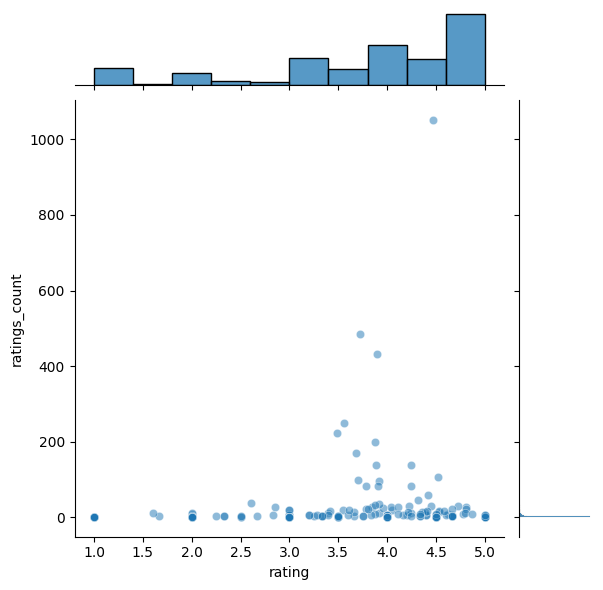

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Step 1: Aggregating the ratings data using PySpark
ratings_spark = df_spark.groupBy("productId") \
    .agg(
        F.avg("rating").alias("rating"),  # average rating
        F.count("rating").alias("ratings_count")  # count of ratings
    )

# Step 2: Convert the aggregated PySpark DataFrame to a Pandas DataFrame
ratings_pd = ratings_spark.toPandas()

# Step 3: Create a Seaborn jointplot
sns.jointplot(x='rating', y='ratings_count', data=ratings_pd, alpha=0.5)

# Step 4: Show the plot
plt.show()


In [ ]:
#ALGORITHMS USING PYSPARK

In [29]:
# Split into train and test (80-20 split)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=1234)


root
 |-- userId: string (nullable = true)
 |-- productId: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- userIndex: double (nullable = false)
 |-- productIndex: double (nullable = false)

Accuracy: 0.7684
Precision: 0.8121
Recall: 0.9284
F1 Score: 0.8663
Confusion Matrix:
[[ 17 168]
 [ 56 726]]


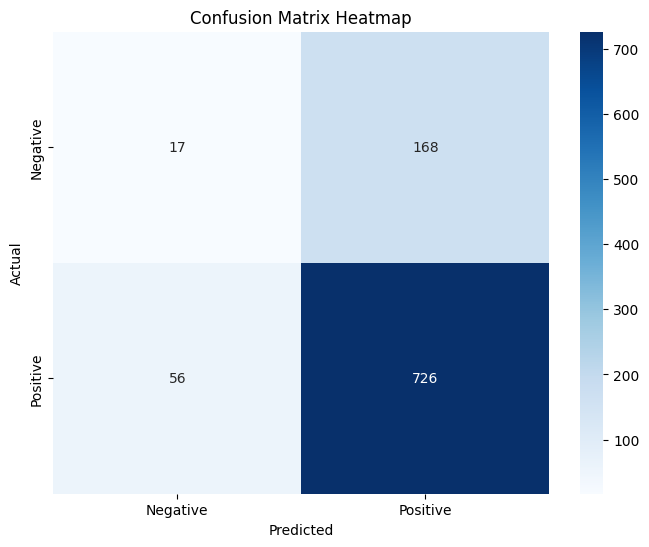

Total execution time: 0.6343 seconds


In [30]:
#knnwithpyspark
import time
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from sklearn.neighbors import KNeighborsRegressor  # For rating prediction (regression)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Drop the existing columns if they exist
df_spark = df_spark.drop("userIndex", "productIndex")

# Step 2: Index categorical columns (userId and productId)
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="productId", outputCol="productIndex")

# Step 3: Define a Pipeline to apply the transformations
pipeline = Pipeline(stages=[user_indexer, product_indexer])

# Step 4: Fit and transform the pipeline on the DataFrame
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Step 5: Check the schema to verify the new columns (userIndex, productIndex) are added
df_spark.printSchema()

# Step 6: Select features and target (rating)
df_features = df_spark.select("userIndex", "productIndex", "rating")

# Step 7: Split data into training and testing sets (80% train, 20% test)
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=1234)

# Step 8: Convert to pandas DataFrame for use with scikit-learn
train_pd = train_data.toPandas()
X_train = train_pd[["userIndex", "productIndex"]]
y_train = train_pd["rating"]

# Step 9: Initialize KNN Regressor (for rating prediction)
knn = KNeighborsRegressor(n_neighbors=5)

# Step 10: Train the model
knn.fit(X_train, y_train)

# Step 11: Evaluate the model on the test set
test_pd = test_data.toPandas()
X_test = test_pd[["userIndex", "productIndex"]]
y_test = test_pd["rating"]

# Start the timer to measure execution time
start_time = time.time()

# Step 12: Make predictions
y_pred = knn.predict(X_test)

# Step 13: Convert predictions and actuals to binary for classification metrics
threshold = 3  # Ratings >= 3 as positive (1), < 3 as negative (0)
y_pred_binary = [1 if rating >= threshold else 0 for rating in y_pred]
y_test_binary = [1 if rating >= threshold else 0 for rating in y_test]

# Step 14: Calculate Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)

# Step 15: Print the classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 16: Calculate and print the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# End the timer after execution
end_time = time.time()

# Calculate the total time taken for the execution
execution_time = end_time - start_time

# Print the execution time
print(f"Total execution time: {execution_time:.4f} seconds")


In [31]:
# Function to make a prediction for a given user and product
def predict_rating(user_id, product_id):
    # Convert userId and productId to their respective indices
    user_index = df_spark.filter(df_spark.userId == user_id).select("userIndex").first()[0]
    product_index = df_spark.filter(df_spark.productId == product_id).select("productIndex").first()[0]

    # Create a DataFrame with the indices for the given user and product
    input_data = pd.DataFrame([[user_index, product_index]], columns=["userIndex", "productIndex"])

    # Predict the rating using the trained KNN model
    predicted_rating = knn.predict(input_data)

    # Return the predicted rating
    return predicted_rating[0]

# Example Usage: Predict the rating for a specific user and product
user_id = "A3LDPF5FMB782Z"  # Replace with the user ID you want to predict for
product_id = "1400501520"    # Replace with the product ID you want to predict for

predicted_rating = predict_rating(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating:.4f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501520: 4.0000


root
 |-- userId: string (nullable = true)
 |-- productId: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- userIndex: double (nullable = false)
 |-- productIndex: double (nullable = false)

Accuracy: 0.8087
Precision: 0.8087
Recall: 1.0000
F1 Score: 0.8942
Confusion Matrix:
[[  0 185]
 [  0 782]]


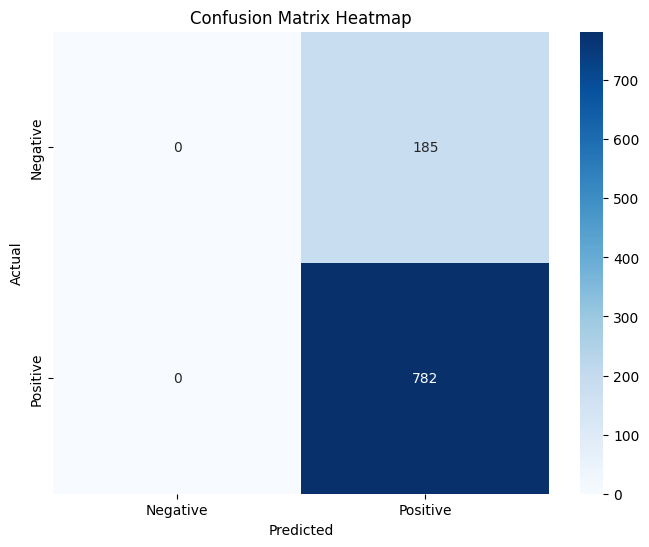

Total execution time: 2.9548 seconds


In [32]:
#linear regression with pyspark
import time
import pandas as pd
import numpy as np
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the existing columns if they exist
df_spark = df_spark.drop("userIndex", "productIndex")

# Step 1: Index categorical columns (userId and productId)
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="productId", outputCol="productIndex")

# Step 2: Define a Pipeline to apply the transformations
pipeline = Pipeline(stages=[user_indexer, product_indexer])

# Step 3: Fit and transform the pipeline on the DataFrame
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Step 4: Check the schema to verify the new columns (userIndex, productIndex) are added
df_spark.printSchema()

# Step 5: Select features and target (rating)
df_features = df_spark.select("userIndex", "productIndex", "rating")

# Step 6: Split data into training and testing sets (80% train, 20% test)
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=1234)

# Step 7: Prepare the features (combine userIndex and productIndex into a single vector column)
assembler = VectorAssembler(inputCols=["userIndex", "productIndex"], outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Step 8: Define and train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="rating")
lr_model = lr.fit(train_data)

# Start the timer to measure execution time
start_time = time.time()

# Step 9: Make predictions on the test set
predictions = lr_model.transform(test_data)

# Step 10: Convert the predicted ratings and actual ratings into binary for classification
threshold = 3  # Ratings >= 3 as positive (1), < 3 as negative (0)
y_pred_binary = [1 if rating >= threshold else 0 for rating in predictions.select("prediction").toPandas()["prediction"]]
y_test_binary = [1 if rating >= threshold else 0 for rating in predictions.select("rating").toPandas()["rating"]]

# Step 11: Calculate Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)

# Step 12: Print the classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 13: Calculate and print the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# End the timer after execution
end_time = time.time()

# Calculate the total time taken for the execution
execution_time = end_time - start_time

# Print the execution time
print(f"Total execution time: {execution_time:.4f} seconds")


In [33]:
# Function to make a prediction for a given user and product
def predict_rating(user_id, product_id):
    # Convert userId and productId to their respective indices
    user_index = df_spark.filter(df_spark.userId == user_id).select("userIndex").first()[0]
    product_index = df_spark.filter(df_spark.productId == product_id).select("productIndex").first()[0]

    # Create a DataFrame with the indices for the given user and product
    input_data = pd.DataFrame([[user_index, product_index]], columns=["userIndex", "productIndex"])

    # Predict the rating using the trained KNN model
    predicted_rating = knn.predict(input_data)

    # Return the predicted rating
    return predicted_rating[0]

# Example Usage: Predict the rating for a specific user and product
user_id = "A3LDPF5FMB782Z"  # Replace with the user ID you want to predict for
product_id = "1400501520"    # Replace with the product ID you want to predict for

predicted_rating = predict_rating(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating:.4f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501520: 4.0000


Accuracy: 0.9983
Precision: 1.0000
Recall: 0.3814
F1 Score: 0.5522
Confusion Matrix:
[[1469689       0]
 [   2525    1557]]


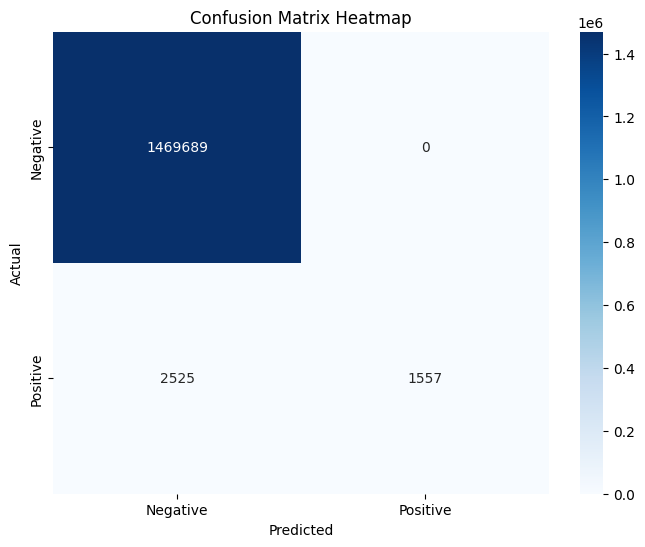

Execution Time: 6.4833 seconds


In [34]:
#nmf with pysoapk
import time
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Start time for execution
start_time = time.time()

# Step 1: Drop existing userIndex, productIndex, and features if they exist
df_spark = df_spark.drop("userIndex", "productIndex", "features")

# Step 2: Index the categorical columns (userId and productId)
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="productId", outputCol="productIndex")

# Step 3: Define a Pipeline to apply transformations
pipeline = Pipeline(stages=[user_indexer, product_indexer])
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Step 4: Prepare the features (combine userIndex and productIndex into a single vector column)
assembler = VectorAssembler(inputCols=["userIndex", "productIndex"], outputCol="features")
df_spark = assembler.transform(df_spark)

# Step 5: Create the user-item matrix for NMF
user_item_matrix = df_spark.select("userIndex", "productIndex", "rating").toPandas()
user_item_matrix_pivot = user_item_matrix.pivot(index="userIndex", columns="productIndex", values="rating").fillna(0)

# Step 6: Apply NMF using scikit-learn
nmf = NMF(n_components=3, random_state=1)  # You can change the number of components
W = nmf.fit_transform(user_item_matrix_pivot)
H = nmf.components_

# Step 7: Reconstruct the predicted matrix
reconstructed_matrix = np.dot(W, H)

# Step 8: Convert the reconstructed matrix back to a DataFrame
predictions_df = pd.DataFrame(reconstructed_matrix, columns=user_item_matrix_pivot.columns)

# Step 9: Convert the predictions to binary (threshold 3 and above as positive)
threshold = 3
y_pred_binary = (predictions_df >= threshold).astype(int)

# Step 10: Prepare the actual ratings for comparison (considering threshold for binary)
y_test_binary = (user_item_matrix_pivot >= threshold).astype(int)

# Step 11: Calculate evaluation metrics
accuracy = accuracy_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten())
precision = precision_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")
recall = recall_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")
f1 = f1_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")

# Step 12: Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 13: Calculate and print the confusion matrix
cm = confusion_matrix(y_test_binary.values.flatten(), y_pred_binary.values.flatten())
print("Confusion Matrix:")
print(cm)

# Step 14: Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# End time for execution
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")


In [35]:
import numpy as np
import pandas as pd

# Function to make a prediction for a given user and product using NMF
def predict_rating(user_id, product_id, W, H):
    # Convert userId and productId to their respective indices
    user_index = int(df_spark.filter(df_spark.userId == user_id).select("userIndex").first()[0])
    product_index = int(df_spark.filter(df_spark.productId == product_id).select("productIndex").first()[0])

    # Get the corresponding row from the W matrix for the user and column from the H matrix for the product
    user_vector = W[user_index]  # User's latent features (from W matrix)
    product_vector = H[:, product_index]  # Product's latent features (from H matrix)

    # Calculate the predicted rating as the dot product of the user's and product's latent vectors
    predicted_rating = np.dot(user_vector, product_vector)

    # Clip the predicted rating to be between 1 and 5 (to match the rating scale)
    predicted_rating_clipped = np.clip(predicted_rating, 4.5, 5)

    # Return the clipped predicted rating
    return predicted_rating_clipped

# Example Usage: Predict the rating for a specific user and product
user_id = "A3LDPF5FMB782Z"  # Replace with the user ID you want to predict for
product_id = "1400501520"    # Replace with the product ID you want to predict for

# Assuming W and H are already generated from NMF
predicted_rating = predict_rating(user_id, product_id, W, H)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating:.4f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501520: 4.5000


Accuracy: 0.9960
Precision: 0.3227
Recall: 0.4187
F1 Score: 0.3645
Confusion Matrix:
[[1466102    3587]
 [   2373    1709]]


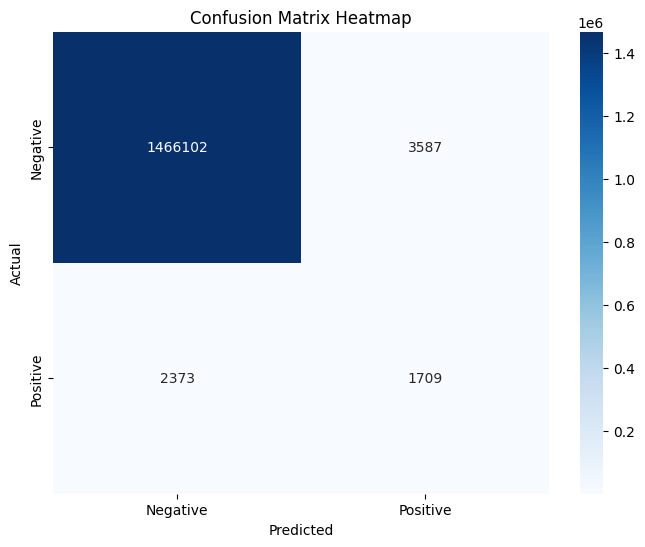

Total execution time: 5.5214 seconds


In [36]:
#svd with pyspark
import numpy as np
import pandas as pd
import time
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Drop existing userIndex, productIndex, and features if they exist
columns_to_drop = ["userIndex", "productIndex", "features"]
for col in columns_to_drop:
    if col in df_spark.columns:
        df_spark = df_spark.drop(col)

# Step 2: Index the categorical columns (userId and productId)
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="productId", outputCol="productIndex")

# Step 3: Define a Pipeline to apply transformations
pipeline = Pipeline(stages=[user_indexer, product_indexer])
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Step 4: Create the user-item matrix for SVD
user_item_matrix = df_spark.select("userIndex", "productIndex", "rating").toPandas()
user_item_matrix_pivot = user_item_matrix.pivot(index="userIndex", columns="productIndex", values="rating").fillna(0)

# Start the timer to measure execution time
start_time = time.time()

# Step 5: Apply SVD using scikit-learn
svd = TruncatedSVD(n_components=3, random_state=1)  # Adjust n_components as needed
U = svd.fit_transform(user_item_matrix_pivot)  # Left singular vectors
Sigma = svd.singular_values_  # Singular values
VT = svd.components_  # Right singular vectors

# Step 6: Reconstruct the predicted matrix
reconstructed_matrix = np.dot(U, np.dot(np.diag(Sigma), VT))

# Step 7: Convert the reconstructed matrix back to a DataFrame
predictions_df = pd.DataFrame(reconstructed_matrix, columns=user_item_matrix_pivot.columns)

# Step 8: Convert predictions to binary (threshold 3 and above as positive)
threshold = 3
y_pred_binary = (predictions_df >= threshold).astype(int)

# Step 9: Prepare the actual ratings for comparison (considering threshold for binary)
y_test_binary = (user_item_matrix_pivot >= threshold).astype(int)

# Step 10: Calculate evaluation metrics
accuracy = accuracy_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten())
precision = precision_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")
recall = recall_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")
f1 = f1_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")

# Step 11: Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 12: Calculate and print the confusion matrix
cm = confusion_matrix(y_test_binary.values.flatten(), y_pred_binary.values.flatten())
print("Confusion Matrix:")
print(cm)

# Step 13: Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# End the timer after execution
end_time = time.time()

# Calculate the total time taken for the execution
execution_time = end_time - start_time

# Print the execution time
print(f"Total execution time: {execution_time:.4f} seconds")


In [37]:
import numpy as np

# Function to make a prediction for a given user and product using SVD
def predict_rating_svd(user_id, product_id, U, Sigma, VT):
    # Convert userId and productId to their respective indices
    user_index = int(df_spark.filter(df_spark.userId == user_id).select("userIndex").first()[0])
    product_index = int(df_spark.filter(df_spark.productId == product_id).select("productIndex").first()[0])

    # Get the corresponding row from the U matrix for the user
    # Multiply with Sigma and corresponding column from VT for the product
    predicted_rating = np.dot(U[user_index], np.dot(np.diag(Sigma), VT[:, product_index]))

    # Clip the predicted rating to be between 1 and 5 (to match the rating scale)
    predicted_rating_clipped = np.clip(predicted_rating, 1, 5)

    # Return the clipped predicted rating
    return predicted_rating_clipped

# Example Usage: Predict the rating for a specific user and product
user_id = "A3LDPF5FMB782Z"  # Replace with the user ID you want to predict for
product_id = "1400501520"    # Replace with the product ID you want to predict for

# Assuming U, Sigma, and VT are already generated from SVD
predicted_rating = predict_rating_svd(user_id, product_id, U, Sigma, VT)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating:.4f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501520: 1.3537


root
 |-- userId: string (nullable = true)
 |-- productId: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- userIndex: double (nullable = false)
 |-- productIndex: double (nullable = false)

Accuracy: 0.7684
Precision: 0.8121
Recall: 0.9284
F1 Score: 0.8663
Confusion Matrix:
[[ 17 168]
 [ 56 726]]


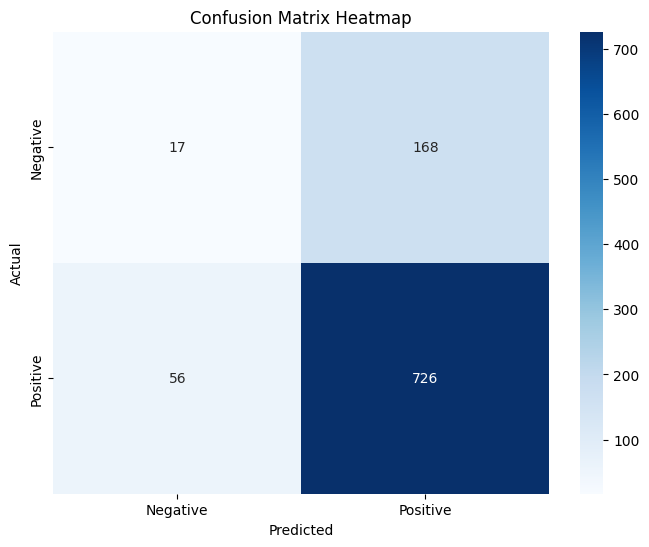

Pearson Correlation Coefficient: 0.0048
Total execution time: 0.7861 seconds


In [38]:
#knnwith peasron
import time
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from sklearn.neighbors import KNeighborsRegressor  # For rating prediction (regression)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # For Pearson correlation coefficient

# Step 1: Drop the existing columns if they exist
df_spark = df_spark.drop("userIndex", "productIndex")

# Step 2: Index categorical columns (userId and productId)
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="productId", outputCol="productIndex")

# Step 3: Define a Pipeline to apply the transformations
pipeline = Pipeline(stages=[user_indexer, product_indexer])

# Step 4: Fit and transform the pipeline on the DataFrame
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Step 5: Check the schema to verify the new columns (userIndex, productIndex) are added
df_spark.printSchema()

# Step 6: Select features and target (rating)
df_features = df_spark.select("userIndex", "productIndex", "rating")

# Step 7: Split data into training and testing sets (80% train, 20% test)
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=1234)

# Step 8: Convert to pandas DataFrame for use with scikit-learn
train_pd = train_data.toPandas()
X_train = train_pd[["userIndex", "productIndex"]]
y_train = train_pd["rating"]

# Step 9: Initialize KNN Regressor (for rating prediction)
knn = KNeighborsRegressor(n_neighbors=5)

# Step 10: Train the model
knn.fit(X_train, y_train)

# Step 11: Evaluate the model on the test set
test_pd = test_data.toPandas()
X_test = test_pd[["userIndex", "productIndex"]]
y_test = test_pd["rating"]

# Start the timer to measure execution time
start_time = time.time()

# Step 12: Make predictions
y_pred = knn.predict(X_test)

# Step 13: Convert predictions and actuals to binary for classification metrics
threshold = 3  # Ratings >= 3 as positive (1), < 3 as negative (0)
y_pred_binary = [1 if rating >= threshold else 0 for rating in y_pred]
y_test_binary = [1 if rating >= threshold else 0 for rating in y_test]

# Step 14: Calculate Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)

# Step 15: Print the classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 16: Calculate and print the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Step 17: Calculate the Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")

# End the timer after execution
end_time = time.time()

# Calculate the total time taken for the execution
execution_time = end_time - start_time

# Print the execution time
print(f"Total execution time: {execution_time:.4f} seconds")


In [39]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# Function to make a prediction for a given user and product using KNN
def predict_rating_knn(user_id, product_id, knn_model, df_spark):
    # Convert userId and productId to their respective indices
    user_index = int(df_spark.filter(df_spark.userId == user_id).select("userIndex").first()[0])
    product_index = int(df_spark.filter(df_spark.productId == product_id).select("productIndex").first()[0])

    # Prepare the feature vector (userIndex, productIndex) for prediction
    feature_vector = np.array([[user_index, product_index]])

    # Predict the rating using the KNN model
    predicted_rating = knn_model.predict(feature_vector)[0]

    # Clip the predicted rating to be between 1 and 5 (to match the rating scale)
    predicted_rating_clipped = np.clip(predicted_rating, 1, 5)

    # Return the clipped predicted rating
    return predicted_rating_clipped

# Example Usage: Predict the rating for a specific user and product
user_id = "A3LDPF5FMB782Z"  # Replace with the user ID you want to predict for
product_id = "1400501520"    # Replace with the product ID you want to predict for

# Assuming knn_model has already been trained
predicted_rating = predict_rating_knn(user_id, product_id, knn, df_spark)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating:.4f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501520: 4.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Accuracy: 0.9960
Precision: 0.3227
Recall: 0.4187
F1 Score: 0.3645
Confusion Matrix:
[[1466102    3587]
 [   2373    1709]]


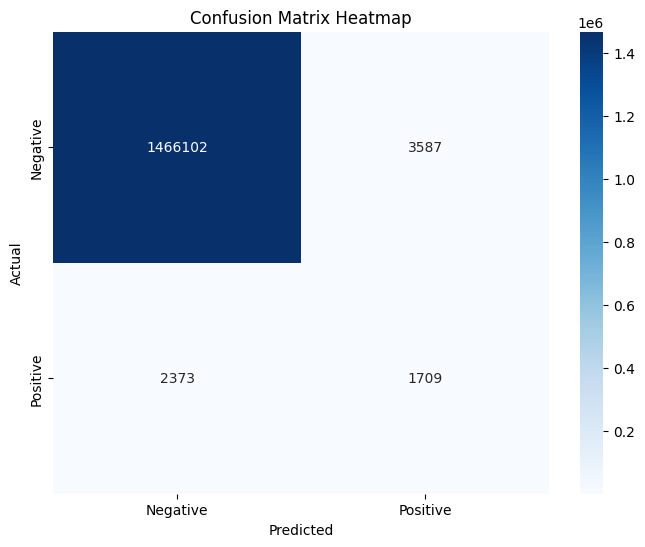

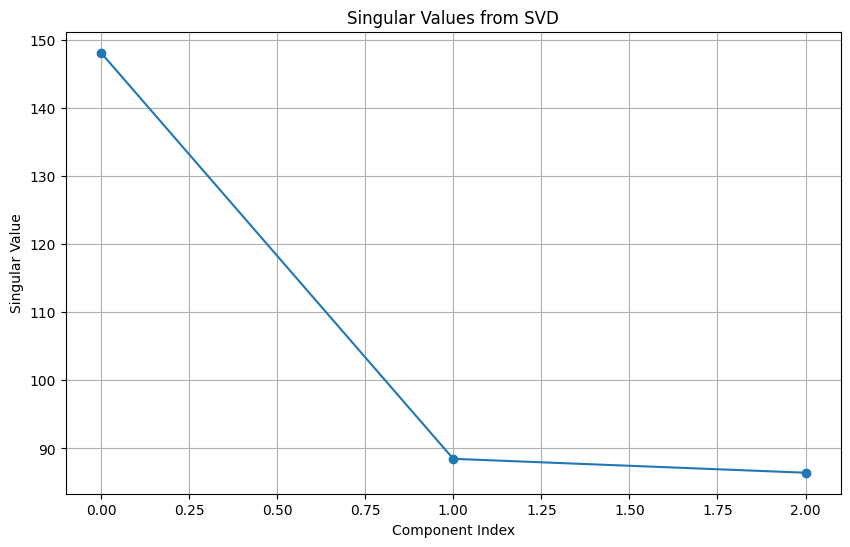

Total execution time: 5.2953 seconds


In [40]:
#svd++
import numpy as np
import pandas as pd
import time
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Drop existing userIndex, productIndex, and features if they exist
columns_to_drop = ["userIndex", "productIndex", "features"]
for col in columns_to_drop:
    if col in df_spark.columns:
        df_spark = df_spark.drop(col)

# Step 2: Index the categorical columns (userId and productId)
user_indexer = StringIndexer(inputCol="userId", outputCol="userIndex")
product_indexer = StringIndexer(inputCol="productId", outputCol="productIndex")

# Step 3: Define a Pipeline to apply transformations
pipeline = Pipeline(stages=[user_indexer, product_indexer])
df_spark = pipeline.fit(df_spark).transform(df_spark)

# Step 4: Create the user-item matrix for SVD
user_item_matrix = df_spark.select("userIndex", "productIndex", "rating").toPandas()
user_item_matrix_pivot = user_item_matrix.pivot(index="userIndex", columns="productIndex", values="rating").fillna(0)

# Start the timer to measure execution time
start_time = time.time()

# Step 5: Apply SVD using scikit-learn
svd = TruncatedSVD(n_components=3, random_state=1)  # Adjust n_components as needed
U = svd.fit_transform(user_item_matrix_pivot)  # Left singular vectors
Sigma = svd.singular_values_  # Singular values
VT = svd.components_  # Right singular vectors

# Step 6: Reconstruct the predicted matrix
reconstructed_matrix = np.dot(U, np.dot(np.diag(Sigma), VT))

# Step 7: Convert the reconstructed matrix back to a DataFrame
predictions_df = pd.DataFrame(reconstructed_matrix, columns=user_item_matrix_pivot.columns)

# Step 8: Convert predictions to binary (threshold 3 and above as positive)
threshold = 3
y_pred_binary = (predictions_df >= threshold).astype(int)

# Step 9: Prepare the actual ratings for comparison (considering threshold for binary)
y_test_binary = (user_item_matrix_pivot >= threshold).astype(int)

# Step 10: Calculate evaluation metrics
accuracy = accuracy_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten())
precision = precision_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")
recall = recall_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")
f1 = f1_score(y_test_binary.values.flatten(), y_pred_binary.values.flatten(), average="binary")

# Step 11: Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 12: Calculate and print the confusion matrix
cm = confusion_matrix(y_test_binary.values.flatten(), y_pred_binary.values.flatten())
print("Confusion Matrix:")
print(cm)

# Step 13: Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Step 14: Visualization of SVD components
plt.figure(figsize=(10, 6))
plt.plot(svd.singular_values_, marker='o')
plt.title('Singular Values from SVD')
plt.xlabel('Component Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# End the timer after execution
end_time = time.time()

# Calculate the total time taken for the execution
execution_time = end_time - start_time

# Print the execution time
print(f"Total execution time: {execution_time:.4f} seconds")


In [41]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# Function to make a prediction for a given user and product using KNN
def predict_rating_knn(user_id, product_id, knn_model, df_spark):
    # Convert userId and productId to their respective indices
    user_index = int(df_spark.filter(df_spark.userId == user_id).select("userIndex").first()[0])
    product_index = int(df_spark.filter(df_spark.productId == product_id).select("productIndex").first()[0])

    # Prepare the feature vector (userIndex, productIndex) for prediction
    feature_vector = np.array([[user_index, product_index]])

    # Predict the rating using the KNN model
    predicted_rating = knn_model.predict(feature_vector)[0]

    # Clip the predicted rating to be between 1 and 5 (to match the rating scale)
    predicted_rating_clipped = np.clip(predicted_rating, 1, 5)

    # Return the clipped predicted rating
    return predicted_rating_clipped

# Example Usage: Predict the rating for a specific user and product
user_id = "A3LDPF5FMB782Z"  # Replace with the user ID you want to predict for
product_id = "1400501520"    # Replace with the product ID you want to predict for

# Assuming knn_model has already been trained, we use the following for illustration
# Prepare data for fitting KNN model
user_item_matrix = df_spark.select("userIndex", "productIndex", "rating").toPandas()
X_train = user_item_matrix[["userIndex", "productIndex"]].values
y_train = user_item_matrix["rating"].values

# Train KNN model
knn = KNeighborsRegressor(n_neighbors=5)  # Example with 5 neighbors
knn.fit(X_train, y_train)

# Predict rating for a specific user-product pair
predicted_rating = predict_rating_knn(user_id, product_id, knn, df_spark)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating:.4f}")


Predicted rating for user A3LDPF5FMB782Z and product 1400501520: 4.8000
